In [1]:
import numpy as np
import pandas as pd

import tensorflow
import keras
from keras import optimizers
from keras import losses
from keras.losses import mse, binary_crossentropy
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Lambda, Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard


import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import sys
import os
import glob

In [2]:
class visualization:
    labels = ["Normal", "Anomaly"]
    def draw_confusion_matrix(self, y, y_pred):
        matrix = confusion_matrix(y_true=y, y_pred=y_pred)
        
        plt.figure(figsize=(7,5))
        colors =['orange', 'green']
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels,
                   cmap=colors, annot=True, fmt='d')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        
        
    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error':error, 'true':y}).groupby('true')
        
        figure, axes = plt.subplots(figsize=(12, 8))
        
        for name, group in groupsDF:
            axes.plot(group.index, group.error, linestyle='',
                      marker='x' if name == 1 else 'o',
                      color='r' if name == 1 else 'g',
                      label='Anomaly' if name == 1 else 'Normal'
                      )
        axes.hlines(threshold, xmin=axes.get_xlim()[0], xmax=axes.get_xlim()[1],
                   colors='b', zorder=100, label='Threshold')
        axes.legend()

        plt.title("Anomalies")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.show()
            
    def draw_error(self, error, threshold):
        figure, axes = plt.subplots(figsize=(12, 8))
        plt.plot(error, marker='o', ms=3.5, linestyle='', label='Point')
        plt.hlines(threshold, xmin=0, xmax=len(error)-1,
                   colors='b', zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.show()
        

## Load Data

In [3]:
data_folder = os.path.join('D:', os.sep, 'DS', 'DL', 'data', 'ts')
print(data_folder)

D:\DS\DL\data\ts


In [4]:
data_file_list = os.listdir(data_folder)

In [5]:
# df = pd.read_csv(os.path.join(data_folder, data_file_list[-2])
#                  , header=0, sep=',')

df = pd.read_csv('../data/ts/nyc_taxi.csv')

In [6]:
print(df.shape)
df.head(2)

(10320, 2)


,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127


In [7]:
df['Datetime'] = pd.to_datetime(df['timestamp'])

In [8]:
df.head(2)

,timestamp,value,Datetime
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  object        
 1   value      10320 non-null  int64         
 2   Datetime   10320 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 242.0+ KB


## Data Understanding

Text(0.5, 1.0, 'Newyork taxi demands (Time series)')

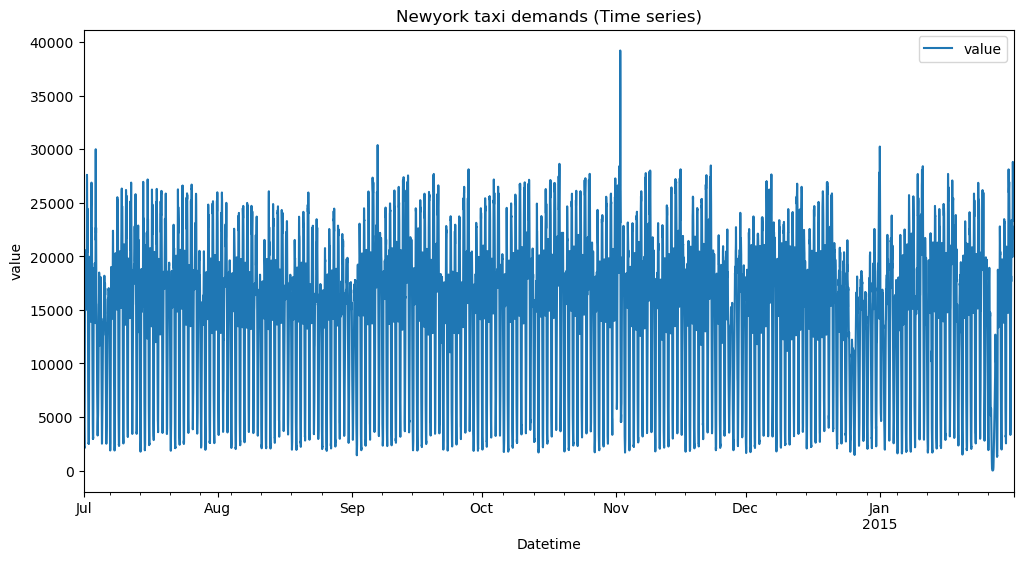

In [10]:
df.plot(x='Datetime', y="value", figsize=(12, 6))
plt.xlabel('Datetime')
plt.ylabel('value')
plt.title("Newyork taxi demands (Time series)")

count    10320.000000
mean     15137.569380
std       6939.495808
min          8.000000
25%      10262.000000
50%      16778.000000
75%      19838.750000
max      39197.000000
Name: value, dtype: float64


<Axes: >

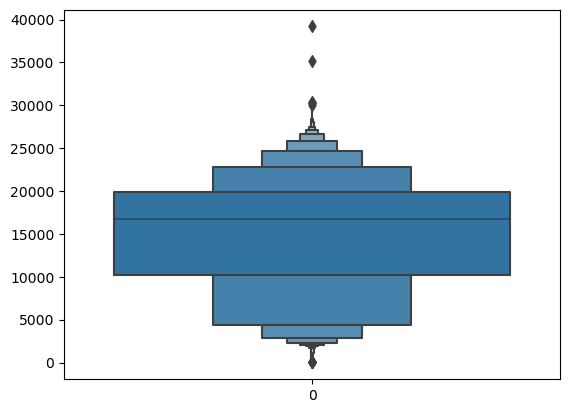

In [11]:
print(df['value'].describe())
sns.boxenplot(df['value'])


<Axes: title={'center': 'Value before scaling'}, xlabel='value', ylabel='Density'>

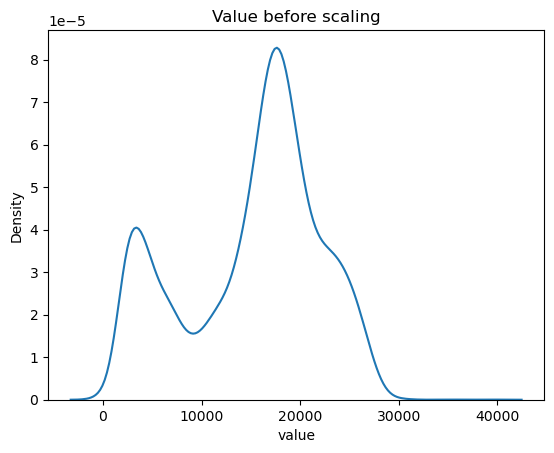

In [12]:
plt.title('Value before scaling')
sns.kdeplot(df['value'])

## Scale data

In [13]:
scaler = MinMaxScaler()
df['scaled_value'] = scaler.fit_transform(df['value'].values.reshape(-1,1))

In [14]:
print(df.shape)
df.head()

(10320, 4)


,timestamp,value,Datetime,scaled_value
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00,0.276506
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00,0.207175
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00,0.158259
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00,0.118605
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00,0.097272


count    10320.000000
mean         0.386067
std          0.177078
min          0.000000
25%          0.261655
50%          0.427926
75%          0.506028
max          1.000000
Name: scaled_value, dtype: float64


<Axes: title={'center': 'Value after scaling'}, xlabel='scaled_value', ylabel='Density'>

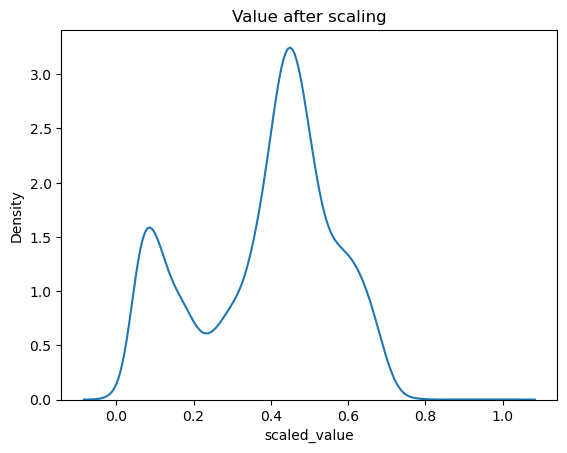

In [15]:
print(df['scaled_value'].describe())
plt.title('Value after scaling')
sns.kdeplot(df['scaled_value'])

## Create model

In [16]:
time_step = 48
metric = ['mean_absolute_error']
# metric = ['accuracy']

model = Sequential()
model.add(LSTM(units=32, activation='tanh', input_shape=(time_step, 1) ,return_sequences=True))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 32)            4352      
                                                                 
 dense (Dense)               (None, 48, 1)             33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Temporary drop some last rows to check trimmed dataset sequence
sequence = np.array(df.drop(df.tail(3000).index)['scaled_value'])

# sequence = np.array(df['scaled_value'])
# print(sequence)

time_step = 48
samples = len(sequence) # samples count
print(f'samples count: {samples}\n')

trim = samples % time_step

# subsequences counts
# how many sub sequences could be reterived from main sequence basd on time step
subsequences = int(samples / time_step)

# get rid of remainig data based on time step reminder
sequence_trimmed = sequence[:samples - trim]

print(f'samples - trim = {samples - trim} \n')

print(f'samples: {samples}, subsequences: {subsequences} \n')

sequence_trimmed.shape = (subsequences, time_step, 1)
print(f'sequence_trimmed: {sequence_trimmed.shape}')


samples count: 7320

samples - trim = 7296 

samples: 7320, subsequences: 152 

sequence_trimmed: (152, 48, 1)


In [19]:
# additional calculation to show detailed operations at last cell
print(f'subsequences: {samples / time_step}')
print(f'subsequences (rounded): {int(samples / time_step)}')
print(f'samples remainig : {int(samples / time_step)}')

subsequences: 152.5
subsequences (rounded): 152
samples remainig : 152


In [20]:
# Browse training sequence data
print(len(sequence_trimmed[0]))
sequence_trimmed[0].reshape(1,-1)

48


array([[0.27650616, 0.20717548, 0.1582587 , 0.11860471, 0.09727219,
        0.07310725, 0.0602465 , 0.0524637 , 0.05646993, 0.05486233,
        0.06397203, 0.11115364, 0.16632218, 0.28148205, 0.35338998,
        0.40462885, 0.45706703, 0.51897216, 0.49837965, 0.51287351,
        0.48421751, 0.45196356, 0.43994488, 0.47092296, 0.48227819,
        0.48171681, 0.46365051, 0.49633826, 0.49855827, 0.52522391,
        0.49432239, 0.47298987, 0.41389165, 0.38288806, 0.43877108,
        0.4980224 , 0.58582766, 0.70402409, 0.6843502 , 0.63528031,
        0.58350558, 0.52019699, 0.59692771, 0.62341473, 0.59480977,
        0.55436475, 0.51279696, 0.41090612]])

In [21]:
# compare sequences with original data to check tollering frame
# NOTE: Each time frame represents a row
step_no = 2
time_step = 48
ctrl_df = pd.DataFrame(sequence_trimmed[step_no], columns=['sequence'])
ctrl_df['value'] =  np.array(df[step_no * time_step: (step_no + 1) * 48]['scaled_value'])

ctrl_df['flag'] = ctrl_df.apply(lambda x: 1 if  x['sequence'] == x['value'] else 0, axis=1)

print(f"Values available in column: {ctrl_df['flag'].value_counts()}\n")
ctrl_df

Values available in column: 1    48
Name: flag, dtype: int64



,sequence,value,flag
0,0.322488,0.322488,1
1,0.269310,0.269310,1
2,0.214550,0.214550,1
3,0.180918,0.180918,1
4,0.148460,0.148460,1
5,0.111638,0.111638,1
6,0.083238,0.083238,1
7,0.075021,0.075021,1
8,0.080073,0.080073,1
9,0.078313,0.078313,1


In [22]:
log_dir = os.path.join('D:', os.sep, 'DS', 'DL', 'Concepts', 'logs', 'LSTM-NYC-01')
print(log_dir)
from shutil import rmtree
rmtree(log_dir, ignore_errors=True)

D:\DS\DL\Concepts\logs\LSTM-NYC-01


In [23]:
training_dataset = sequence_trimmed
print("training_dataset: ", training_dataset.shape)

batch_size=64
epochs=200

history = model.fit(x=training_dataset, y=training_dataset,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(training_dataset, training_dataset),
                    callbacks=[TensorBoard(log_dir=log_dir)])

training_dataset:  (152, 48, 1)
Epoch 1/200
3/3 [==============================] - 1s 189ms/step - loss: 0.1516 - mean_absolute_error: 0.1516 - val_loss: 0.1497 - val_mean_absolute_error: 0.1497
Epoch 2/200
3/3 [==============================] - 0s 50ms/step - loss: 0.1493 - mean_absolute_error: 0.1493 - val_loss: 0.1483 - val_mean_absolute_error: 0.1483
Epoch 3/200
3/3 [==============================] - 0s 36ms/step - loss: 0.1480 - mean_absolute_error: 0.1480 - val_loss: 0.1474 - val_mean_absolute_error: 0.1474
Epoch 4/200
3/3 [==============================] - 0s 39ms/step - loss: 0.1471 - mean_absolute_error: 0.1471 - val_loss: 0.1463 - val_mean_absolute_error: 0.1463
Epoch 5/200
3/3 [==============================] - 0s 32ms/step - loss: 0.1461 - mean_absolute_error: 0.1461 - val_loss: 0.1452 - val_mean_absolute_error: 0.1452
Epoch 6/200
3/3 [==============================] - 0s 40ms/step - loss: 0.1449 - mean_absolute_error: 0.1449 - val_loss: 0.1439 - val_mean_absolute_error: 0.

3/3 [==============================] - 0s 32ms/step - loss: 0.0548 - mean_absolute_error: 0.0548 - val_loss: 0.0542 - val_mean_absolute_error: 0.0542
Epoch 52/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0541 - mean_absolute_error: 0.0541 - val_loss: 0.0535 - val_mean_absolute_error: 0.0535
Epoch 53/200
3/3 [==============================] - 0s 57ms/step - loss: 0.0534 - mean_absolute_error: 0.0534 - val_loss: 0.0529 - val_mean_absolute_error: 0.0529
Epoch 54/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0528 - mean_absolute_error: 0.0528 - val_loss: 0.0521 - val_mean_absolute_error: 0.0521
Epoch 55/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0518 - mean_absolute_error: 0.0518 - val_loss: 0.0518 - val_mean_absolute_error: 0.0518
Epoch 56/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0516 - mean_absolute_error: 0.0516 - val_loss: 0.0512 - val_mean_absolute_error: 0.0512
Epoch 57/200
3/3 [=================

3/3 [==============================] - 0s 49ms/step - loss: 0.0310 - mean_absolute_error: 0.0310 - val_loss: 0.0307 - val_mean_absolute_error: 0.0307
Epoch 102/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.0304 - val_mean_absolute_error: 0.0304
Epoch 103/200
3/3 [==============================] - 0s 43ms/step - loss: 0.0304 - mean_absolute_error: 0.0304 - val_loss: 0.0302 - val_mean_absolute_error: 0.0302
Epoch 104/200
3/3 [==============================] - 0s 52ms/step - loss: 0.0303 - mean_absolute_error: 0.0303 - val_loss: 0.0302 - val_mean_absolute_error: 0.0302
Epoch 105/200
3/3 [==============================] - 0s 47ms/step - loss: 0.0300 - mean_absolute_error: 0.0300 - val_loss: 0.0300 - val_mean_absolute_error: 0.0300
Epoch 106/200
3/3 [==============================] - 0s 50ms/step - loss: 0.0298 - mean_absolute_error: 0.0298 - val_loss: 0.0298 - val_mean_absolute_error: 0.0298
Epoch 107/200
3/3 [===========

3/3 [==============================] - 0s 48ms/step - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0221 - val_mean_absolute_error: 0.0221
Epoch 152/200
3/3 [==============================] - 0s 41ms/step - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0220 - val_mean_absolute_error: 0.0220
Epoch 153/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0220 - mean_absolute_error: 0.0220 - val_loss: 0.0218 - val_mean_absolute_error: 0.0218
Epoch 154/200
3/3 [==============================] - 0s 49ms/step - loss: 0.0219 - mean_absolute_error: 0.0219 - val_loss: 0.0217 - val_mean_absolute_error: 0.0217
Epoch 155/200
3/3 [==============================] - 0s 53ms/step - loss: 0.0218 - mean_absolute_error: 0.0218 - val_loss: 0.0218 - val_mean_absolute_error: 0.0218
Epoch 156/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0218 - mean_absolute_error: 0.0218 - val_loss: 0.0219 - val_mean_absolute_error: 0.0219
Epoch 157/200
3/3 [===========

In [24]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

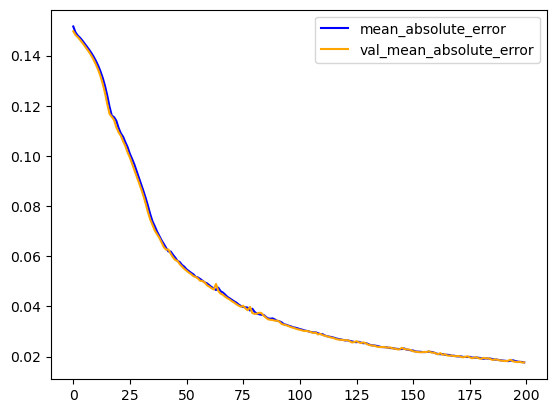

In [25]:
plt.plot(history.history['mean_absolute_error'], color='b', label='mean_absolute_error')
plt.plot(history.history['val_mean_absolute_error'], color='orange', label='val_mean_absolute_error')
plt.legend()

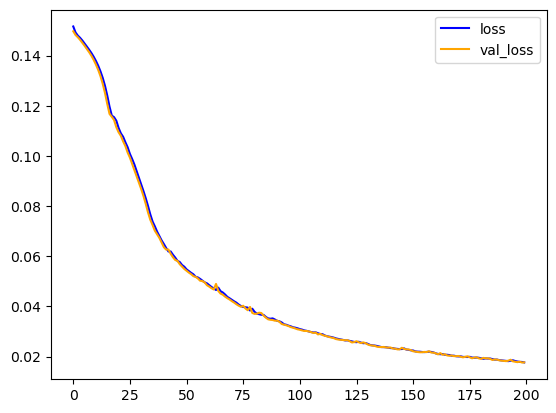

In [26]:
plt.plot(history.history['loss'], color='b', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
plt.legend()

## Predict and test

In [27]:
import math
from sklearn.metrics import mean_squared_error

In [28]:
sequence = np.array(df['scaled_value'])
print(f'sequence.shape: {sequence.shape} \n')
time_step = 48
samples = len(sequence)
trim = samples % time_step
subsequences = int(samples/time_step)
sequence_trimmed = sequence[:samples - trim]

sequence_trimmed.shape = (subsequences, time_step, 1)
print(sequence_trimmed.shape)

##############################################################

testing_dataset = sequence_trimmed
print("testing_dataset: ", testing_dataset.shape)

testing_pred = model.predict(x=testing_dataset)
print("testing_pred shape: ", testing_pred.shape)

testing_dataset = testing_dataset.reshape((testing_dataset.shape[0]*testing_dataset.shape[1]), testing_dataset.shape[2])
print("testing_dataset shape: ", testing_dataset.shape)

testing_pred = testing_pred.reshape((testing_pred.shape[0]*testing_pred.shape[1]), testing_pred.shape[2])
print("testing_pred new shape: ", testing_pred.shape)

errorsDF = testing_dataset - testing_pred
print(errorsDF.shape)

rmse = math.sqrt(mean_squared_error(testing_dataset, testing_pred))
print('Test RMSE: %.3f' % rmse)

sequence.shape: (10320,) 

(215, 48, 1)
testing_dataset:  (215, 48, 1)
7/7 [==============================] - 0s 2ms/step
testing_pred shape:  (215, 48, 1)
testing_dataset shape:  (10320, 1)
testing_pred new shape:  (10320, 1)
(10320, 1)
Test RMSE: 0.032


## Thresholding

--------------------
**1- dist means distance from origin or original value which represent Error**<br/>
**2- np.linalg.norm returns matrix L1 norm (aka: absolute value)**<br/>
**3- define threshold based on cutoff after sorting errors.**<br/>

In [200]:
dist = np.linalg.norm(testing_dataset - testing_pred, axis=-1)

scores = dist.copy()
print(f'scores shape: {scores.shape}')

scores.sort()
cutoff = int(0.9995 * len(scores))
print(f'cutoff: {cutoff}')
print(scores[cutoff:])

threshold= scores[cutoff]
print(f'threshold: {threshold}')

scores shape: (10320,)
cutoff: 10314
[0.22883256 0.23115473 0.25251742 0.31595677 0.34355157 0.38127476]
threshold: 0.2288325612579813


### Concept:

In [201]:
n = 5
d1 = testing_dataset[0:n]#.reshape(1, -1)
d2 = testing_pred[0:n]#.reshape(1, -1)

print(d1[0:n].reshape(1, -1))
print(d2[0:n].reshape(1, -1))
print(d1[0:n] - d2[0:n])

norm = np.linalg.norm(d1 - d2, ord=2, axis=-1)
print("*" * 50)
print(norm.shape)


[[0.27650616 0.20717548 0.1582587  0.11860471 0.09727219]]
[[0.39382035 0.3035373  0.2131991  0.1409655  0.09515086]]
[[-0.11731418]
 [-0.09636183]
 [-0.0549404 ]
 [-0.0223608 ]
 [ 0.00212134]]
**************************************************
(5,)


In [202]:
print('norms: ', norm[:n])
print('scores:', dist[:n])
dist[:n] == norm[:n]

norms:  [0.11731418 0.09636183 0.0549404  0.0223608  0.00212134]
scores: [0.11731418 0.09636183 0.0549404  0.0223608  0.00212134]


array([ True,  True,  True,  True,  True])

-----------------------

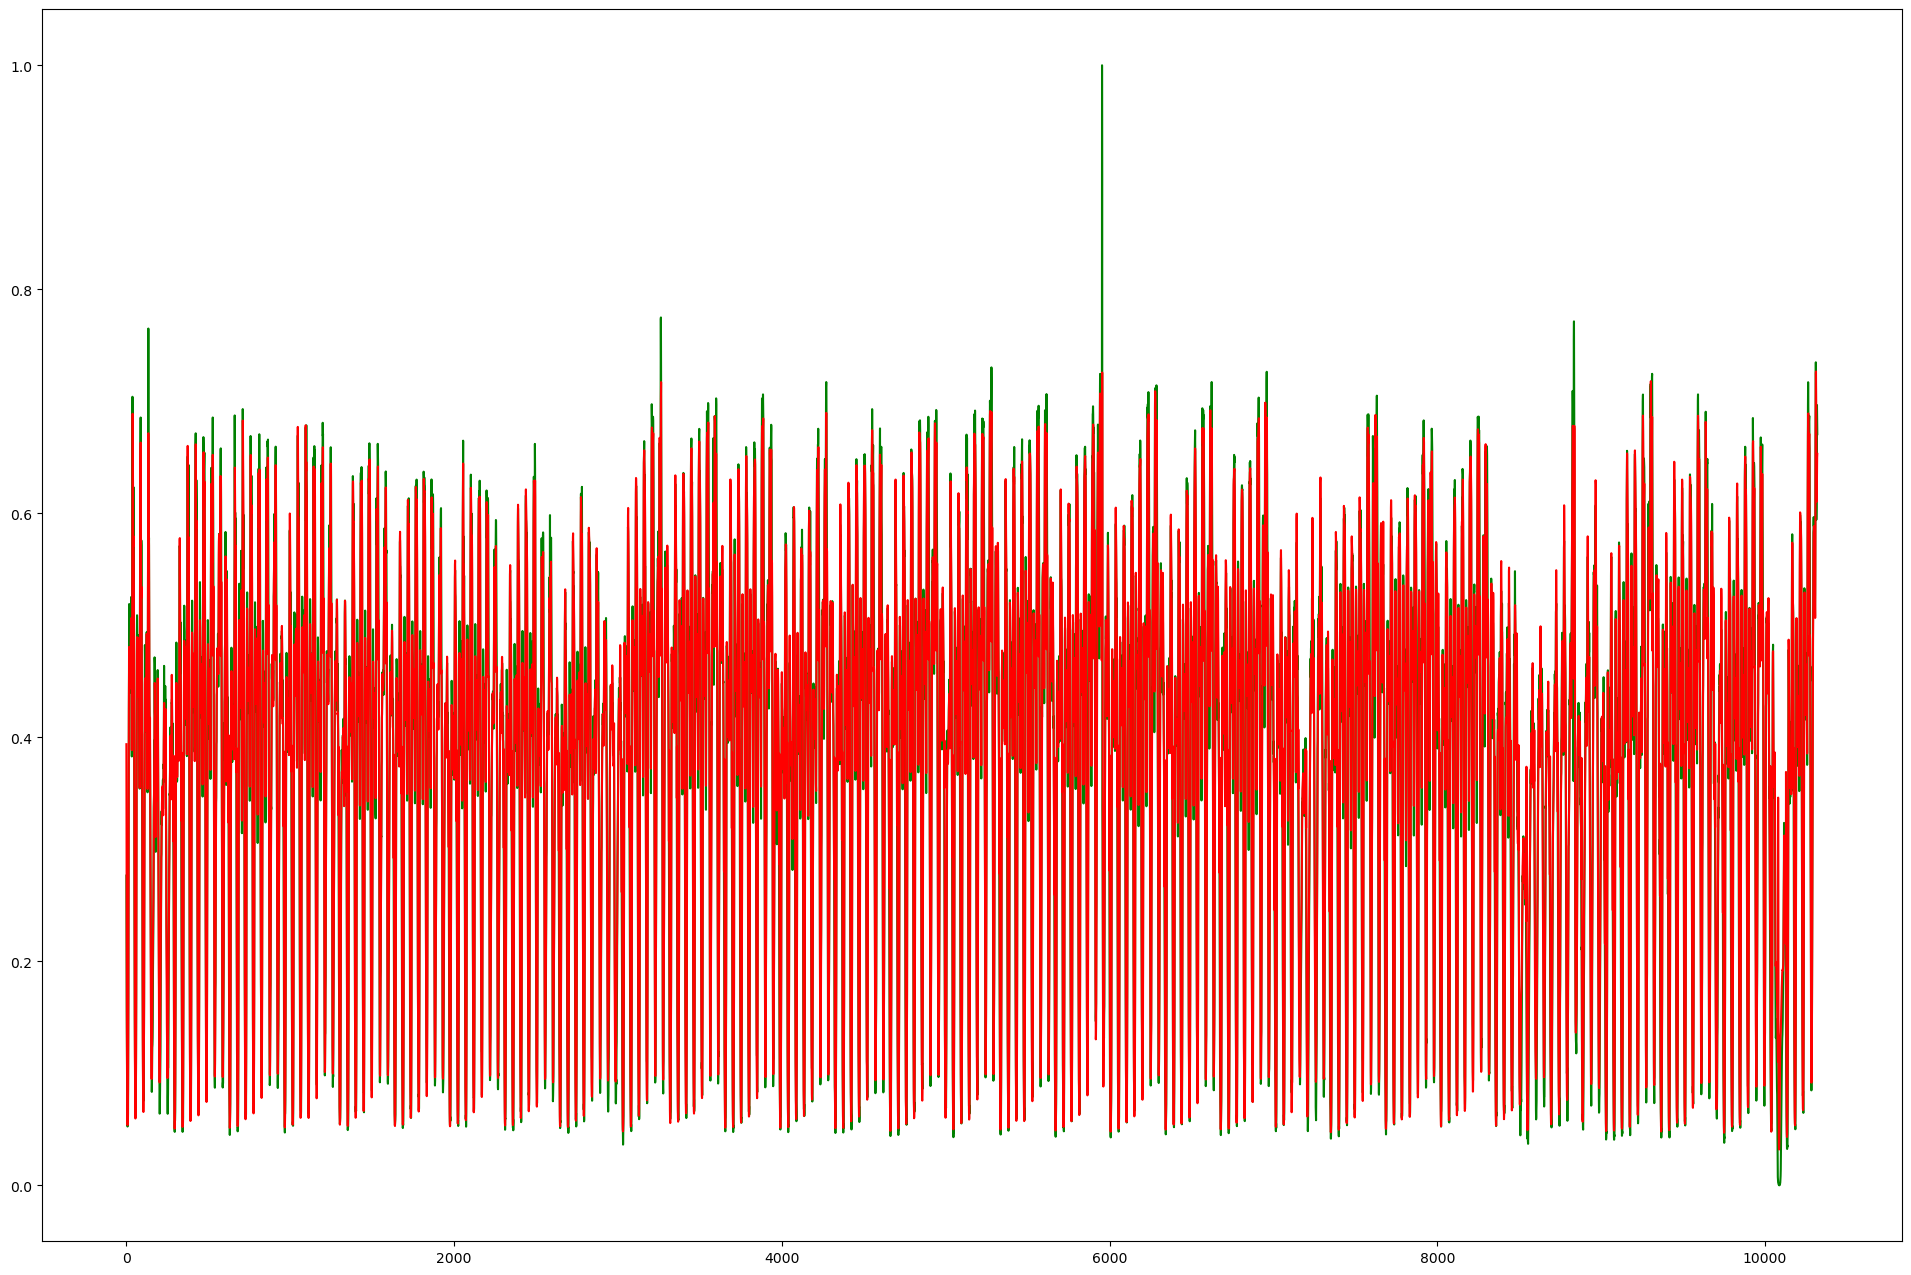

In [203]:
plt.figure(figsize=(24,16))
plt.plot(testing_dataset, color='green')
plt.plot(testing_pred, color='red')

In [204]:
#label the records anomalies or not based on threshold
z = zip(dist >= threshold, dist)

y_label=[]
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)

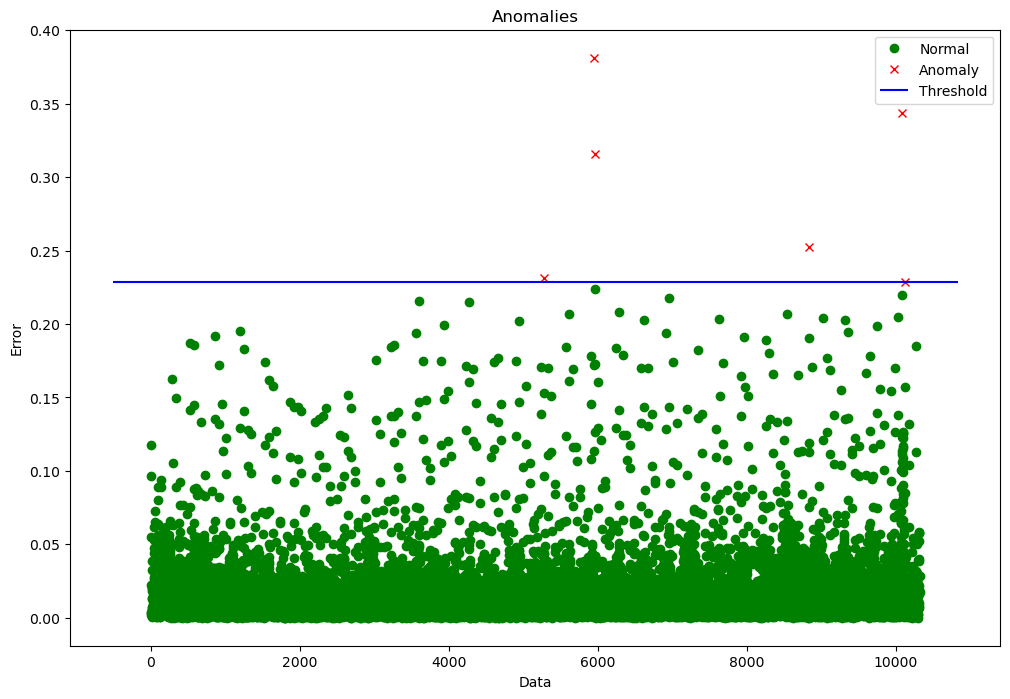

In [205]:
viz = visualization()
viz.draw_anomaly(y_label, error, threshold)

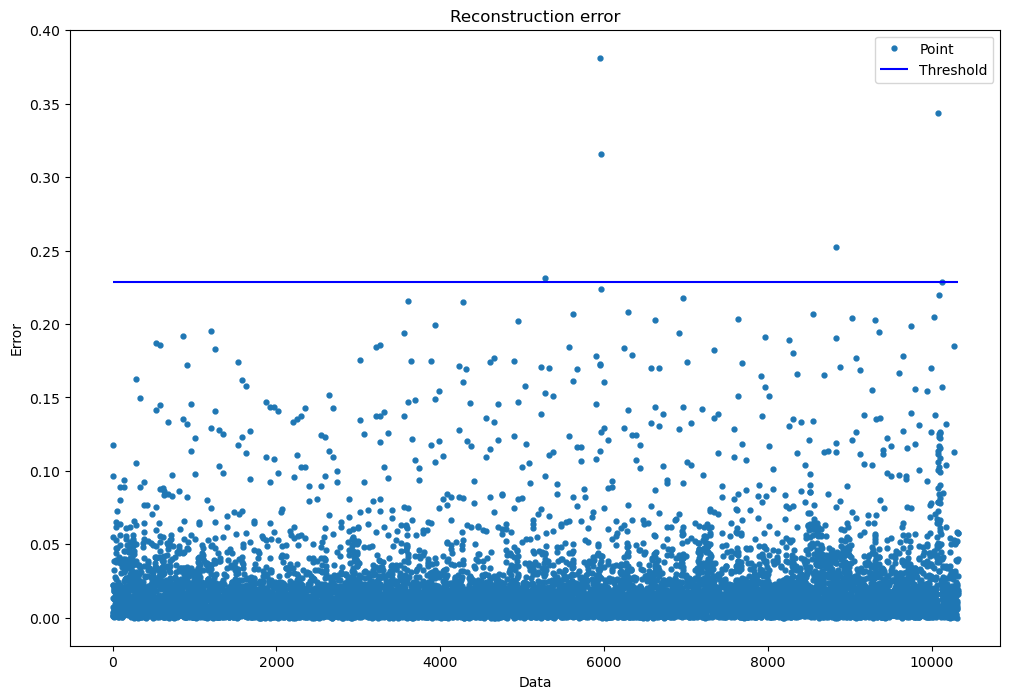

In [206]:
viz.draw_error(error, threshold)

In [207]:
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation': df['value'],
                    'error': error, 'anomaly': y_label})
adf.head(5)

,Datetime,observation,error,anomaly
0,2014-07-01 00:00:00,10844,0.117314,0
1,2014-07-01 00:30:00,8127,0.096362,0
2,2014-07-01 01:00:00,6210,0.054940,0
3,2014-07-01 01:30:00,4656,0.022361,0
4,2014-07-01 02:00:00,3820,0.002121,0


In [208]:
print(adf['anomaly'].value_counts())
adf[adf['anomaly'] == 1].sort_values(by='error', ascending=False)

0    10314
1        6
Name: anomaly, dtype: int64


,Datetime,observation,error,anomaly
5954,2014-11-02 01:00:00,39197,0.381275,1
10080,2015-01-27 00:00:00,109,0.343552,1
5956,2014-11-02 02:00:00,13259,0.315957,1
8833,2015-01-01 00:30:00,29547,0.252517,1
5280,2014-10-19 00:00:00,28093,0.231155,1
10128,2015-01-28 00:00:00,5502,0.228833,1


Text(0.5, 1.0, 'Time Series of value by date time')

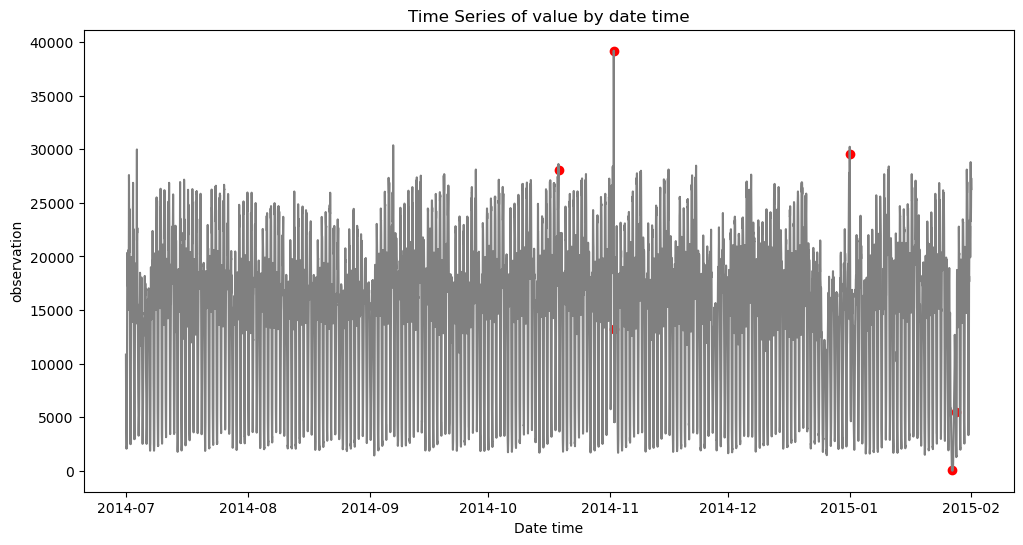

In [209]:
figure, axes = plt.subplots(figsize=(12, 6))
axes.plot(adf['Datetime'], adf['observation'], color='gray')

anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color='r')

plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')

In [210]:
import plotly.express as px
import plotly.graph_objects as go

In [211]:
(anomaliesDF['error'].values * 100).astype(int)

array([23, 38, 31, 25, 34, 22])

In [212]:
fig = px.line(adf, 'Datetime', 'observation')

fig.add_trace(go.Scatter(x=anomaliesDF['Datetime'], y=anomaliesDF['observation'],
                         mode="markers", 
                         name="anomaly",
                         marker=dict(color='red',size=anomaliesDF['error'].values * 100)
                        ))

# fig = px.scatter(data_frame=anomaliesDF,x='Datetime', y='observation', 
#                  size='error', color='error')

# px.scatter(anomaliesDF,'Datetime', 'observation', color='r')
fig.show()